# BERTweet with Interweaving Fine-Tuned Approach on Disability and Nationality

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Imports

In [2]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.5 MB/s eta 0:00:00


In [3]:
!pip install -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 11.4 MB/s eta 0:00:00


In [4]:
!pip3 install -q emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_addons as tfa
import transformers
from transformers import AutoTokenizer,TFRobertaModel

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Functions and Constants

In [7]:
def to_arrays(df):
  X = df['comment_text'].to_numpy()
  y = df['toxicity_binary'].to_numpy()
  return X, y

In [8]:
MAX_SEQUENCE_LENGTH = 128

In [9]:
def tokenizing_pipeline(X, tokenizer):
  bert_tokenized = tokenizer(list(X),
                max_length=MAX_SEQUENCE_LENGTH,
                truncation=True,
                padding='max_length',
                return_tensors='tf')
  bert_inputs = [bert_tokenized.input_ids,
                 bert_tokenized.token_type_ids,
                 bert_tokenized.attention_mask]
  return bert_inputs

def load_data(group):
  df_train = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-train-augmented.csv')
  df_val = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-val-augmented.csv')
  df_test = pd.read_csv('drive/MyDrive/data/' + group + '-dataset-test-augmented.csv')

  return df_train, df_val, df_test

def load_data_as_arr(df_train, df_val, df_test):

  X_train, y_train = to_arrays(df_train)
  X_val, y_val = to_arrays(df_val)
  X_test, y_test = to_arrays(df_test)

  return X_train, y_train, X_test, y_test, X_val, y_val

In [10]:
def build_bertweet_cls_model(max_sequence_length=MAX_SEQUENCE_LENGTH,
                          hidden_size=100, 
                          dropout=0.3,
                          learning_rate=0.0001,
                          num_train_layers=0):

    # freeze all pre-trained BERTweet layers
    if num_train_layers == 0:
      bertweet_model.trainable = False

    # partially freeze the first n pre-trained BERTweet layers
    else:
        for layer_num in range(num_train_layers):
            bertweet_model.roberta.encoder.layer[layer_num].trainable = False
    
    input_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_sequence_length,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}      

    # Use the same bertweet model instance
    bert_out = bertweet_model(bert_inputs)

    cls_token = bert_out[0][:, 0, :]

    
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(cls_token)

    hidden = tf.keras.layers.Dropout(dropout)(hidden)  

    f1_score = tfa.metrics.F1Score(1, threshold = 0.5)

    classification = tf.keras.layers.Dense(1, activation='sigmoid', name='classification_layer')(hidden)
    
    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    
    classification_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate),
                                 loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), 
                                 metrics=[tf.keras.metrics.BinaryAccuracy(),
                                        tf.keras.metrics.Precision(),
                                        tf.keras.metrics.Recall(),
                                        f1_score])

    return classification_model

## Load All Available Data for Disability and Nationality

In [11]:
# Disability
disability_train_df, disability_val_df, disability_test_df = load_data('disability')
X_disability_train, y_disability_train, X_disability_test, y_disability_test, X_disability_val, y_disability_val = load_data_as_arr(disability_train_df, disability_val_df, disability_test_df)

# Nationality
nationality_train_df, nationality_val_df, nationality_test_df = load_data('nationality')
X_nationality_train, y_nationality_train, X_nationality_test, y_nationality_test, X_nationality_val, y_nationality_val = load_data_as_arr(nationality_train_df, nationality_val_df, nationality_test_df)

In [12]:
X_disability_train[1]

' mental disability is extremely physical'

In [13]:
X_disability_train[9]

' There are many different types of disabilities. For example: mental, cognitive, visual, hearing, physical, and speech. Some people physically cannot speak English'

In [14]:
len(X_disability_train)

24904

In [15]:
X_nationality_train[0]

' most of the foods of the middle east are very healthy for you'

In [16]:
len(X_nationality_train)

28490

## Load BERTweet Model from_pretrained()

In [17]:
bertweet_tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base",
                                                    use_fast=False,
                                                    normalization=True,
                                                    add_special_tokens=True,
                                                    return_attention_mask=True)
bertweet_model = TFRobertaModel.from_pretrained("vinai/bertweet-base")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some layers from the model checkpoint at vinai/bertweet-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/bertweet-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


In [18]:
bertweet_model.summary()

Model: "tf_roberta_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 134899968 
 )                                                               
                                                                 
Total params: 134,899,968
Trainable params: 134,899,968
Non-trainable params: 0
_________________________________________________________________


## Tokenize Data Splits

In [19]:
# Disability
bertweet_disability_train_inputs = tokenizing_pipeline(X_disability_train, bertweet_tokenizer)
bertweet_disability_test_inputs = tokenizing_pipeline(X_disability_test, bertweet_tokenizer)
bertweet_disability_val_inputs = tokenizing_pipeline(X_disability_val, bertweet_tokenizer)

# Nationality
bertweet_nationality_train_inputs = tokenizing_pipeline(X_nationality_train, bertweet_tokenizer)
bertweet_nationality_test_inputs = tokenizing_pipeline(X_nationality_test, bertweet_tokenizer)
bertweet_nationality_val_inputs = tokenizing_pipeline(X_nationality_val, bertweet_tokenizer)

# Calculate Class Weights for Each Group

Get class weights for disability train set:

In [20]:
neg, pos = np.bincount(y_disability_train)
total = neg + pos
print('Disability Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

disability_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Disability Weight for class 0: {:.2f}'.format(weight_for_0))
print('Disability Weight for class 1: {:.2f}'.format(weight_for_1))

Disability Examples:
    Total: 24904
    Positive: 13009 (52.24% of total)

Disability Weight for class 0: 1.05
Disability Weight for class 1: 0.96


Get class weights for nationality train set:

In [21]:
neg, pos = np.bincount(y_nationality_train)
total = neg + pos
print('Nationality Train Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

nationality_class_weight = {0: weight_for_0, 1: weight_for_1}

print('Nationality Train Weight for class 0: {:.2f}'.format(weight_for_0))
print('Nationality Train Weight for class 1: {:.2f}'.format(weight_for_1))

Nationality Train Examples:
    Total: 28490
    Positive: 14575 (51.16% of total)

Nationality Train Weight for class 0: 1.02
Nationality Train Weight for class 1: 0.98


### Define Hyperparameters for both models

In [22]:
# hyperparameters
batch_size=24
num_train_layers=8
learning_rate=1e-6

# Build Disability Model

In [23]:
disability_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
disability_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                              

# Build Nationality Model

In [24]:
nationality_model = build_bertweet_cls_model(num_train_layers=num_train_layers, learning_rate=learning_rate)
nationality_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 attention_mask_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                                  
 input_ids_layer (InputLayer)   [(None, 128)]        0           []                               
                                                                                                  
 token_type_ids_layer (InputLay  [(None, 128)]       0           []                               
 er)                                                                                              
                                                                                            

# Interweaving Fine-Tuning: Train Disability and Gender Models on ther Respective Data

## Round 1: Train Disability Model for 1 epochs

In [25]:
disability_round1_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 99s 79ms/step - loss: 0.6184 - binary_accuracy: 0.6511 - precision: 0.6772 - recall: 0.6344 - f1_score: 0.6551 - val_loss: 0.4826 - val_binary_accuracy: 0.7683 - val_precision: 0.7706 - val_recall: 0.7877 - val_f1_score: 0.7791


## Round 2: Train Nationality Model for 1 epoch

In [26]:
nationality_round2_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 113s 82ms/step - loss: 0.5724 - binary_accuracy: 0.6996 - precision_1: 0.7183 - recall_1: 0.6792 - f1_score: 0.6982 - val_loss: 0.4254 - val_binary_accuracy: 0.8088 - val_precision_1: 0.8087 - val_recall_1: 0.8252 - val_f1_score: 0.8169


## Round 3: Train Disability Model for 1 epoch

In [27]:
disability_round3_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4664 - binary_accuracy: 0.7880 - precision: 0.8011 - recall: 0.7903 - f1_score: 0.7957 - val_loss: 0.4295 - val_binary_accuracy: 0.7950 - val_precision: 0.8185 - val_recall: 0.7771 - val_f1_score: 0.7972


## Round 4: Train Nationality Model on for 1 epoch

In [28]:
nationality_round4_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.4358 - binary_accuracy: 0.8029 - precision_1: 0.8117 - recall_1: 0.8003 - f1_score: 0.8060 - val_loss: 0.4006 - val_binary_accuracy: 0.8171 - val_precision_1: 0.8377 - val_recall_1: 0.8011 - val_f1_score: 0.8190


## Round 5: Train Disability Model for 1 epoch

In [29]:
disability_round5_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4335 - binary_accuracy: 0.8048 - precision: 0.8247 - recall: 0.7954 - f1_score: 0.8098 - val_loss: 0.4157 - val_binary_accuracy: 0.8085 - val_precision: 0.8468 - val_recall: 0.7701 - val_f1_score: 0.8066


## Round 6: Train Nationality Model for 1 epoch

In [30]:
nationality_round6_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.4060 - binary_accuracy: 0.8200 - precision_1: 0.8301 - recall_1: 0.8151 - f1_score: 0.8225 - val_loss: 0.3826 - val_binary_accuracy: 0.8257 - val_precision_1: 0.8373 - val_recall_1: 0.8223 - val_f1_score: 0.8298



## Round 7: Train Disability Model for 1 epoch

In [31]:
disability_round7_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4170 - binary_accuracy: 0.8144 - precision: 0.8363 - recall: 0.8017 - f1_score: 0.8186 - val_loss: 0.3989 - val_binary_accuracy: 0.8167 - val_precision: 0.8337 - val_recall: 0.8077 - val_f1_score: 0.8205


## Round 8: Train Nationality Model for 1 epoch

In [32]:
nationality_round8_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.3920 - binary_accuracy: 0.8251 - precision_1: 0.8346 - recall_1: 0.8209 - f1_score: 0.8277 - val_loss: 0.3725 - val_binary_accuracy: 0.8303 - val_precision_1: 0.8456 - val_recall_1: 0.8215 - val_f1_score: 0.8334


## Round 9: Train Disability Model for 1 epoch

In [33]:
disability_round9_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.4007 - binary_accuracy: 0.8219 - precision: 0.8448 - recall: 0.8074 - f1_score: 0.8257 - val_loss: 0.3939 - val_binary_accuracy: 0.8186 - val_precision: 0.8525 - val_recall: 0.7863 - val_f1_score: 0.8181


## Round 10: Train Nationality Model for 1 epoch

In [34]:
nationality_round10_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.3778 - binary_accuracy: 0.8331 - precision_1: 0.8411 - recall_1: 0.8307 - f1_score: 0.8358 - val_loss: 0.3651 - val_binary_accuracy: 0.8356 - val_precision_1: 0.8564 - val_recall_1: 0.8191 - val_f1_score: 0.8373


## Checkpoint #1: Save Model Weights for Rounds 9 and 10

In [35]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_disability-checkpt1-rounds_9_10.hdf5')
nationality_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_nationality-checkpt1-rounds_9_10.hdf5')

## Round 11: Train Disability Model for 1 epoch

In [36]:
disability_round11_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3927 - binary_accuracy: 0.8252 - precision: 0.8480 - recall: 0.8108 - f1_score: 0.8290 - val_loss: 0.3853 - val_binary_accuracy: 0.8259 - val_precision: 0.8519 - val_recall: 0.8040 - val_f1_score: 0.8272


## Round 12: Train Nationality Model for 1 epoch

In [37]:
nationality_round12_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.3678 - binary_accuracy: 0.8389 - precision_1: 0.8473 - recall_1: 0.8357 - f1_score: 0.8415 - val_loss: 0.3591 - val_binary_accuracy: 0.8396 - val_precision_1: 0.8496 - val_recall_1: 0.8378 - val_f1_score: 0.8437


## Checkpoint #2: Save Model Weights for Rounds 11 and 12

In [38]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_disability-checkpt1-rounds_11_12.hdf5')
nationality_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_nationality-checkpt1-rounds_11_12.hdf5')

## Round 13: Train Disability Model for 1 epoch

In [39]:
disability_round13_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3823 - binary_accuracy: 0.8308 - precision: 0.8522 - recall: 0.8179 - f1_score: 0.8347 - val_loss: 0.3823 - val_binary_accuracy: 0.8288 - val_precision: 0.8541 - val_recall: 0.8077 - val_f1_score: 0.8303


## Round 14: Train Nationality Model on for 1 epoch

In [40]:
nationality_round14_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.3595 - binary_accuracy: 0.8428 - precision_1: 0.8501 - recall_1: 0.8409 - f1_score: 0.8455 - val_loss: 0.3641 - val_binary_accuracy: 0.8356 - val_precision_1: 0.8723 - val_recall_1: 0.7987 - val_f1_score: 0.8339


## Checkpoint #3: Save Model Weights for Rounds 13 and 14

In [41]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_disability-checkpt2-rounds_13_14.hdf5')
nationality_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_nationality-checkpt2-rounds_13_14.hdf5')

## Round 15: Train Disability Model for 1 epoch

In [42]:
disability_round15_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3751 - binary_accuracy: 0.8363 - precision: 0.8578 - recall: 0.8230 - f1_score: 0.8401 - val_loss: 0.3797 - val_binary_accuracy: 0.8316 - val_precision: 0.8482 - val_recall: 0.8226 - val_f1_score: 0.8352


## Round 16: Train Nationality Model on for 1 epoch

In [43]:
nationality_round16_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.3526 - binary_accuracy: 0.8453 - precision_1: 0.8533 - recall_1: 0.8423 - f1_score: 0.8478 - val_loss: 0.3518 - val_binary_accuracy: 0.8434 - val_precision_1: 0.8651 - val_recall_1: 0.8256 - val_f1_score: 0.8449


## Checkpoint #4: Save Model Weights for Rounds 15 and 16

In [44]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_disability-checkpt3-rounds_15_16.hdf5')
nationality_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_nationality-checkpt3-rounds_15_16.hdf5')

## Round 17: Train Disability Model for 1 epoch

In [45]:
disability_round17_history = disability_model.fit(bertweet_disability_train_inputs,
                                          y_disability_train,
                                          validation_data=(bertweet_disability_val_inputs, y_disability_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=disability_class_weight)

1038/1038 [==============================] - 80s 77ms/step - loss: 0.3703 - binary_accuracy: 0.8390 - precision: 0.8606 - recall: 0.8255 - f1_score: 0.8427 - val_loss: 0.3747 - val_binary_accuracy: 0.8360 - val_precision: 0.8542 - val_recall: 0.8244 - val_f1_score: 0.8390


## Round 18: Train Nationality Model for 1 epoch

In [46]:
nationality_round18_history = nationality_model.fit(bertweet_nationality_train_inputs,
                                          y_nationality_train,
                                          validation_data=(bertweet_nationality_val_inputs, y_nationality_val),
                                          batch_size=batch_size,
                                          epochs=1,
                                          class_weight=nationality_class_weight)

1188/1188 [==============================] - 94s 79ms/step - loss: 0.3439 - binary_accuracy: 0.8518 - precision_1: 0.8588 - recall_1: 0.8502 - f1_score: 0.8545 - val_loss: 0.3444 - val_binary_accuracy: 0.8472 - val_precision_1: 0.8570 - val_recall_1: 0.8452 - val_f1_score: 0.8510


# Plots for Disability Model

In [47]:
disability_train_f1_scores = [disability_round1_history.history['f1_score'][0][0], 
                     disability_round3_history.history['f1_score'][0][0],
                     disability_round5_history.history['f1_score'][0][0],
                     disability_round7_history.history['f1_score'][0][0],
                     disability_round9_history.history['f1_score'][0][0],
                     disability_round11_history.history['f1_score'][0][0],
                     disability_round13_history.history['f1_score'][0][0],
                     disability_round15_history.history['f1_score'][0][0],
                     disability_round17_history.history['f1_score'][0][0]]
disability_val_f1_scores = [disability_round1_history.history['val_f1_score'][0][0],
                     disability_round3_history.history['val_f1_score'][0][0],
                     disability_round5_history.history['val_f1_score'][0][0],
                     disability_round7_history.history['val_f1_score'][0][0],
                     disability_round9_history.history['val_f1_score'][0][0],
                     disability_round11_history.history['val_f1_score'][0][0],
                     disability_round13_history.history['val_f1_score'][0][0],
                     disability_round15_history.history['val_f1_score'][0][0],
                     disability_round17_history.history['val_f1_score'][0][0]]
disability_train_loss = [disability_round1_history.history['loss'][0],
                     disability_round3_history.history['loss'][0],
                     disability_round5_history.history['loss'][0],
                     disability_round7_history.history['loss'][0],
                     disability_round9_history.history['loss'][0],
                     disability_round11_history.history['loss'][0],
                     disability_round13_history.history['loss'][0],
                     disability_round15_history.history['loss'][0],
                     disability_round17_history.history['loss'][0]]
disability_val_loss = [disability_round1_history.history['val_loss'][0],
                     disability_round3_history.history['val_loss'][0],
                     disability_round5_history.history['val_loss'][0],
                     disability_round7_history.history['val_loss'][0],
                     disability_round9_history.history['val_loss'][0],
                     disability_round11_history.history['val_loss'][0],
                     disability_round13_history.history['val_loss'][0],
                     disability_round15_history.history['val_loss'][0],
                     disability_round17_history.history['val_loss'][0]]
disability_train_binary_accuracy = [disability_round1_history.history['binary_accuracy'][0],
                     disability_round3_history.history['binary_accuracy'][0],
                     disability_round5_history.history['binary_accuracy'][0],
                     disability_round7_history.history['binary_accuracy'][0],
                     disability_round9_history.history['binary_accuracy'][0],
                     disability_round11_history.history['binary_accuracy'][0],
                     disability_round13_history.history['binary_accuracy'][0],
                     disability_round15_history.history['binary_accuracy'][0],
                     disability_round17_history.history['binary_accuracy'][0]]
disability_val_binary_accuracy = [disability_round1_history.history['val_binary_accuracy'][0],
                     disability_round3_history.history['val_binary_accuracy'][0],
                     disability_round5_history.history['val_binary_accuracy'][0],
                     disability_round7_history.history['val_binary_accuracy'][0],
                     disability_round9_history.history['val_binary_accuracy'][0],
                     disability_round11_history.history['val_binary_accuracy'][0],
                     disability_round13_history.history['val_binary_accuracy'][0],
                     disability_round15_history.history['val_binary_accuracy'][0],
                     disability_round17_history.history['val_binary_accuracy'][0]]

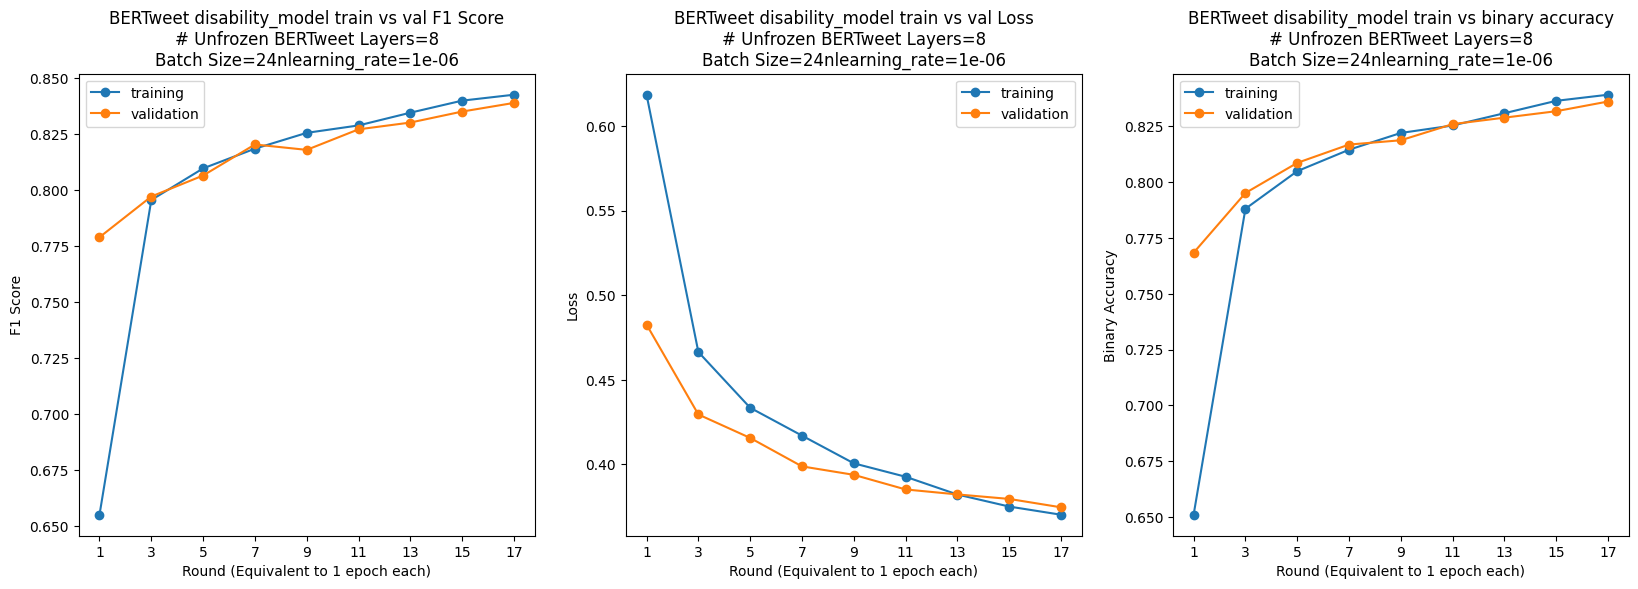

In [48]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(disability_train_f1_scores, label="training", marker='o')
axis[0].plot(disability_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[0].set_title('BERTweet disability_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(disability_train_loss, label="training", marker='o')
axis[1].plot(disability_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[1].set_title('BERTweet disability_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(disability_train_binary_accuracy, label="training", marker='o')
axis[2].plot(disability_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['1', '3', '5', '7', '9', '11', '13', '15', '17'])
axis[2].set_title('BERTweet disability_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Plots for Nationality Model

In [49]:
nationality_train_f1_scores = [nationality_round2_history.history['f1_score'][0][0],
                     nationality_round4_history.history['f1_score'][0][0],
                     nationality_round6_history.history['f1_score'][0][0],
                     nationality_round8_history.history['f1_score'][0][0],
                     nationality_round10_history.history['f1_score'][0][0],
                     nationality_round12_history.history['f1_score'][0][0],
                     nationality_round14_history.history['f1_score'][0][0],
                     nationality_round16_history.history['f1_score'][0][0],
                     nationality_round18_history.history['f1_score'][0][0]]
nationality_val_f1_scores = [nationality_round2_history.history['val_f1_score'][0][0],
                     nationality_round4_history.history['val_f1_score'][0][0],
                     nationality_round6_history.history['val_f1_score'][0][0],
                     nationality_round8_history.history['val_f1_score'][0][0],
                     nationality_round10_history.history['val_f1_score'][0][0],
                     nationality_round12_history.history['val_f1_score'][0][0],
                     nationality_round14_history.history['val_f1_score'][0][0],
                     nationality_round16_history.history['val_f1_score'][0][0],
                     nationality_round18_history.history['val_f1_score'][0][0]]
nationality_train_loss = [nationality_round2_history.history['loss'][0],
                     nationality_round4_history.history['loss'][0],
                     nationality_round6_history.history['loss'][0],
                     nationality_round8_history.history['loss'][0],
                     nationality_round10_history.history['loss'][0],
                     nationality_round12_history.history['loss'][0],
                     nationality_round14_history.history['loss'][0],
                     nationality_round16_history.history['loss'][0],
                     nationality_round18_history.history['loss'][0]]
nationality_val_loss = [nationality_round2_history.history['val_loss'][0],
                     nationality_round4_history.history['val_loss'][0],
                     nationality_round6_history.history['val_loss'][0],
                     nationality_round8_history.history['val_loss'][0],
                     nationality_round10_history.history['val_loss'][0],
                     nationality_round12_history.history['val_loss'][0],
                     nationality_round14_history.history['val_loss'][0],
                     nationality_round16_history.history['val_loss'][0],
                     nationality_round18_history.history['val_loss'][0]]
nationality_train_binary_accuracy = [nationality_round2_history.history['binary_accuracy'][0],
                     nationality_round4_history.history['binary_accuracy'][0],
                     nationality_round6_history.history['binary_accuracy'][0],
                     nationality_round8_history.history['binary_accuracy'][0],
                     nationality_round10_history.history['binary_accuracy'][0],
                     nationality_round12_history.history['binary_accuracy'][0],
                     nationality_round14_history.history['binary_accuracy'][0],
                     nationality_round16_history.history['binary_accuracy'][0],
                     nationality_round18_history.history['binary_accuracy'][0]]
nationality_val_binary_accuracy = [nationality_round2_history.history['val_binary_accuracy'][0],
                     nationality_round4_history.history['val_binary_accuracy'][0],
                     nationality_round6_history.history['val_binary_accuracy'][0],
                     nationality_round8_history.history['val_binary_accuracy'][0],
                     nationality_round10_history.history['val_binary_accuracy'][0],
                     nationality_round12_history.history['val_binary_accuracy'][0],
                     nationality_round14_history.history['val_binary_accuracy'][0],
                     nationality_round16_history.history['val_binary_accuracy'][0],
                     nationality_round18_history.history['val_binary_accuracy'][0]]


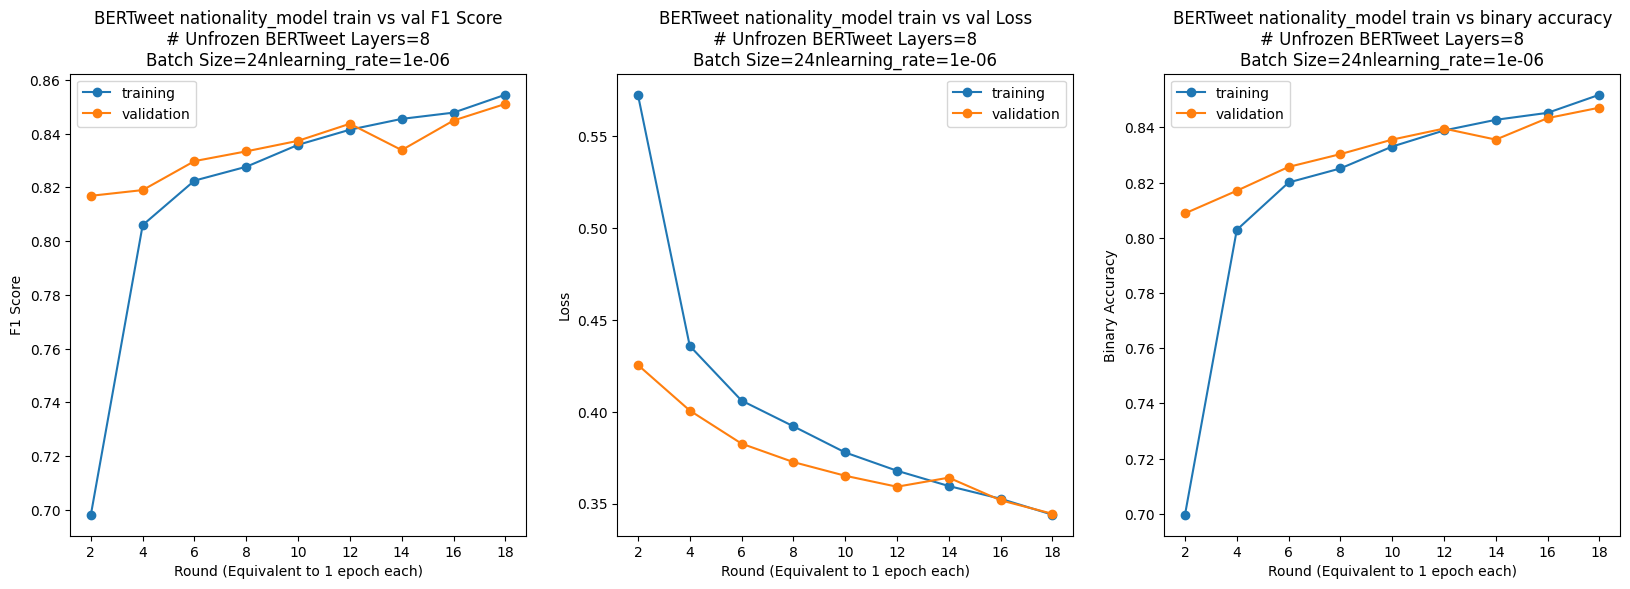

In [50]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(1, 3, figsize=(20,6))

# F1 Score
axis[0].plot(nationality_train_f1_scores, label="training", marker='o')
axis[0].plot(nationality_val_f1_scores, label="validation", marker='o')
axis[0].legend()
axis[0].set_ylabel('F1 Score')
axis[0].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[0].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[0].set_title('BERTweet nationality_model train vs val F1 Score\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Loss
axis[1].plot(nationality_train_loss, label="training", marker='o')
axis[1].plot(nationality_val_loss, label="validation", marker='o')
axis[1].legend()
axis[1].set_ylabel('Loss')
axis[1].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[1].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[1].set_title('BERTweet nationality_model train vs val Loss\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))

# Binary Accuracy
axis[2].plot(nationality_train_binary_accuracy, label="training", marker='o')
axis[2].plot(nationality_val_binary_accuracy, label="validation", marker='o')
axis[2].legend()
axis[2].set_ylabel('Binary Accuracy')
axis[2].set_xlabel('Round (Equivalent to 1 epoch each)')
axis[2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8], ['2', '4', '6', '8', '10', '12', '14', '16', '18'])
axis[2].set_title('BERTweet nationality_model train vs binary accuracy\n'+'# Unfrozen BERTweet Layers='+str(num_train_layers)+'\nBatch Size='+str(batch_size)+'nlearning_rate='+str(learning_rate))
  
# Combine all the operations and display
plt.show()

# Save Final Model Weights if Needed

In [53]:
disability_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_disability_final.hdf5')
nationality_model.save_weights('drive/MyDrive/model_checkpoints/Official_BERTweet_Disability_Nationality_Interwoven_nationality_final.hdf5')

# Keep Previous Results Below/Determine Where to Stop Training

DISABILITY MODEL RESULTS

In [51]:
print('disability_train_f1_scores:', disability_train_f1_scores)
print('disability_val_f1_scores:', disability_val_f1_scores)
print('\ndisability_train_loss:', disability_train_loss)
print('disability_val_loss:', disability_val_loss)
print('\ndisability_train_binary_accuracy:', disability_train_binary_accuracy)
print('disability_val_binary_accuracy:', disability_val_binary_accuracy)

disability_train_f1_scores: [0.6551039, 0.7956815, 0.8097977, 0.8186028, 0.82567513, 0.8289846, 0.83467346, 0.84006125, 0.8427041]
disability_val_f1_scores: [0.7790537, 0.79723614, 0.8066164, 0.8204765, 0.818072, 0.82724017, 0.83026975, 0.83518034, 0.83904517]

disability_train_loss: [0.61839359998703, 0.46642279624938965, 0.43349647521972656, 0.41704583168029785, 0.40068578720092773, 0.3927493393421173, 0.3822636008262634, 0.375146746635437, 0.37032485008239746]
disability_val_loss: [0.48261481523513794, 0.42953237891197205, 0.41567981243133545, 0.39887580275535583, 0.3938899338245392, 0.38525253534317017, 0.3823150098323822, 0.37965455651283264, 0.37470096349716187]

disability_train_binary_accuracy: [0.6510600447654724, 0.7879858613014221, 0.8048104643821716, 0.8144073486328125, 0.8219161629676819, 0.8252489566802979, 0.8307501077651978, 0.8362913727760315, 0.8390218615531921]
disability_val_binary_accuracy: [0.7683044075965881, 0.7950385212898254, 0.8085260391235352, 0.816714823246

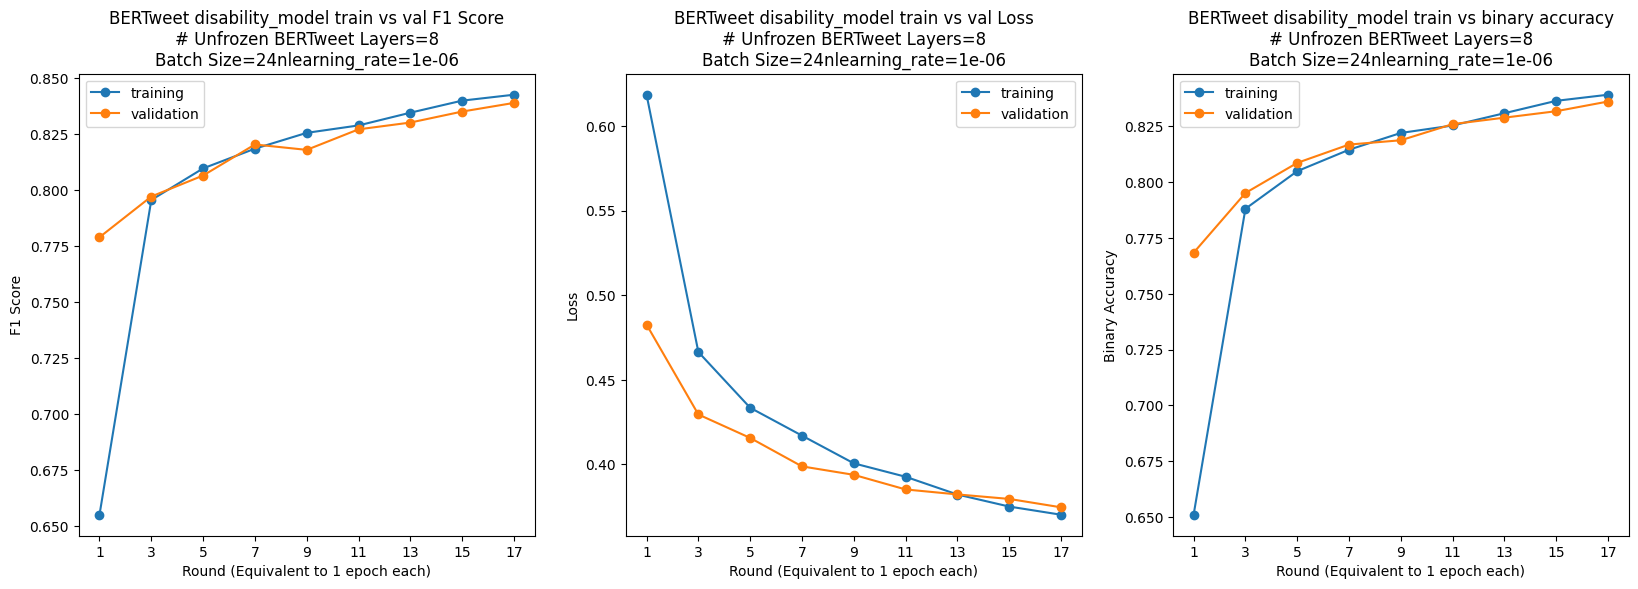

In [ ]:
# DISABILITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the disability_model weights at checkpoint # at round ___

NATIONALITY MODEL RESULTS

In [52]:
print('nationality_train_f1_scores:', nationality_train_f1_scores)
print('nationality_val_f1_scores:', nationality_val_f1_scores)
print('\nnationality_train_loss:', nationality_train_loss)
print('nationality_val_loss:', nationality_val_loss)
print('\nnationality_train_binary_accuracy:', nationality_train_binary_accuracy)
print('nationality_val_binary_accuracy:', nationality_val_binary_accuracy)

nationality_train_f1_scores: [0.69824034, 0.80597013, 0.8225153, 0.82767206, 0.8358302, 0.8414508, 0.8454746, 0.8478006, 0.8544634]
nationality_val_f1_scores: [0.8168616, 0.8189961, 0.82976973, 0.8334022, 0.8373256, 0.84366024, 0.8338651, 0.84487075, 0.8510463]

nationality_train_loss: [0.5723989009857178, 0.43576228618621826, 0.4060019552707672, 0.39201149344444275, 0.3777793049812317, 0.3678256869316101, 0.35950806736946106, 0.3525814414024353, 0.3438969552516937]
nationality_val_loss: [0.42537280917167664, 0.4005886912345886, 0.38257768750190735, 0.3725421130657196, 0.3650999367237091, 0.3591288924217224, 0.3640589118003845, 0.3517647087574005, 0.3444069027900696]

nationality_train_binary_accuracy: [0.6996489763259888, 0.802878201007843, 0.8200421333312988, 0.8251316547393799, 0.8330642580986023, 0.8388908505439758, 0.8427518606185913, 0.8452790379524231, 0.8518427610397339]
nationality_val_binary_accuracy: [0.808842122554779, 0.8170526027679443, 0.8256841897964478, 0.8303157687187

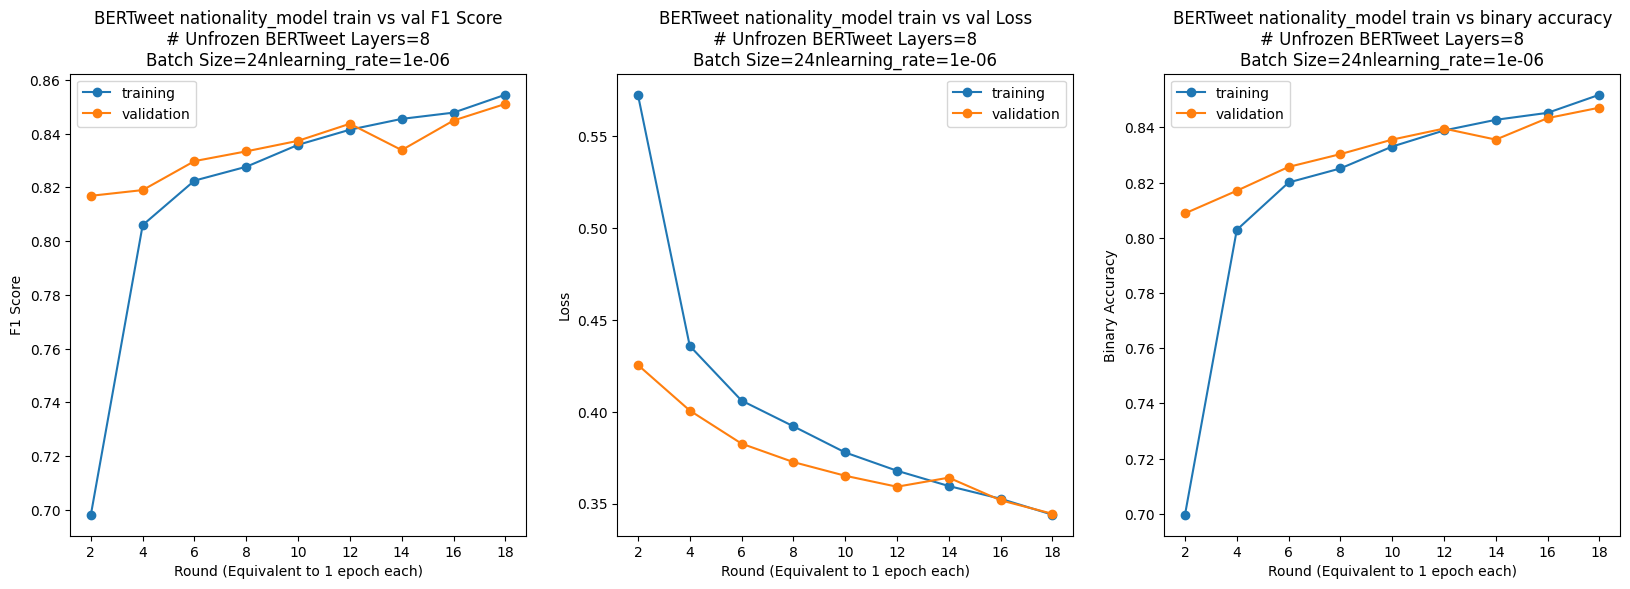

In [ ]:
# NATIONALITY MODEL PLOTS - DON'T RUN THIS CELL
# From the curves below, we'll keep the nationality_model weights at checkpoint # at round ___